# k-ASP Problem

Lee de Byl  
The University of Western Australia  
May 2024  

Experiments to empirically analyse the runtime of different distance oracles.


In [84]:
# Configure Autoreload
%load_ext autoreload
%autoreload 2

# Add parent directory to system path
import os, sys, time, random
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from graph import dynamic_aspl
from synthesis import graph_generator
import pandas as pd

In [128]:
# Given a distance oracle class and a batch of edges to add upon G,
# measure the time taken to intialise and update the oracle
def evaluate(G, batches, oracle):
    start_time = time.time()
    aspl = oracle(G)
    end_time = time.time()
    init_time = end_time - start_time
    
    #print(f"n={n}, r={r}, init_time={init_time}")
    start_time = time.time()
    for batch in batches:
        aspl.evaluate_edges(batch)
    end_time = time.time()
    update_time = end_time - start_time
    #print(f"n={n}, r={r}, update_time={update_time}")
    return init_time, update_time
    
    

In [194]:
results = []
k = 1000
aspl1 = dynamic_aspl.PartiallyDynamicAllPairsShortestPaths
aspl2 = dynamic_aspl.AllPairsShortestPaths

for n in range(25, 325, 25):
    for batch_size in [1, 5, 10, 50, 100, 1000]:
        G = nx.random_regular_graph(10, n=n)
        non_edges = list(nx.non_edges(G))
        # Get the edges in the right format for the oracles
        # Given k total edges we wish to evalaute,
        # generate batches of batch_size to evaluate a total
        # of k edges as a list of lists.
        n_batches = k // batch_size
        print(f"n={n}, n_batches={n_batches}, batch_size={batch_size}")
        batches = [[(u,v,1) for u, v in random.choices(non_edges, k=batch_size)] for i in range(n_batches)]

        for r in range(5):
            init_time, update_time = evaluate(G, batches, aspl1)
            results.append(('PartiallyDynamic', n, k, batch_size, init_time, update_time))
            init_time, update_time = evaluate(G, batches, aspl2)
            results.append(('Simple', n, k, batch_size, init_time, update_time))


n=25, n_batches=1000, batch_size=1
n=25, n_batches=200, batch_size=5
n=25, n_batches=100, batch_size=10
n=25, n_batches=20, batch_size=50
n=25, n_batches=10, batch_size=100
n=25, n_batches=1, batch_size=1000
n=50, n_batches=1000, batch_size=1
n=50, n_batches=200, batch_size=5
n=50, n_batches=100, batch_size=10
n=50, n_batches=20, batch_size=50
n=50, n_batches=10, batch_size=100
n=50, n_batches=1, batch_size=1000
n=75, n_batches=1000, batch_size=1
n=75, n_batches=200, batch_size=5
n=75, n_batches=100, batch_size=10
n=75, n_batches=20, batch_size=50
n=75, n_batches=10, batch_size=100
n=75, n_batches=1, batch_size=1000
n=100, n_batches=1000, batch_size=1
n=100, n_batches=200, batch_size=5
n=100, n_batches=100, batch_size=10
n=100, n_batches=20, batch_size=50
n=100, n_batches=10, batch_size=100
n=100, n_batches=1, batch_size=1000
n=125, n_batches=1000, batch_size=1
n=125, n_batches=200, batch_size=5
n=125, n_batches=100, batch_size=10
n=125, n_batches=20, batch_size=50
n=125, n_batches=10,

In [199]:
df = pd.DataFrame(results, columns=["Method", "Number of Nodes (n)", "Total Edges (k)", "Batch Size", "Initialisation Time (s)", "Update Time (s) per 1000 Edges"])
df.to_pickle("../data/aspl_update_time1000.pkl")

In [248]:
# Fit a polynomial to the observed data using statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit a polynomial to the observed data using statsmodels
df2 = pd.DataFrame(results, columns=["method", "n", "k", "b", "y_init", "y_update"])
df2 = df2[df2['method'] == 'Simple']
model = ols(formula='y_update ~ I(n**2 * k/b)', data=df2).fit()
summary = model.summary()
print(summary)



                            OLS Regression Results                            
Dep. Variable:               y_update   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.439e+06
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        10:55:47   Log-Likelihood:                 89.590
No. Observations:                 360   AIC:                            -175.2
Df Residuals:                     358   BIC:                            -167.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0422      0.01

In [245]:
# Output model parameters with increased precision
params = model.params
print("Intercept: {:.17f}".format(params[0]))
print("Slope:     {:.17f}".format(params[1]))

Intercept: 0.03015963227486718
Slope:     0.00000169559657312


/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_18818/501743999.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Intercept: {:.17f}".format(params[0]))
/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_18818/501743999.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Slope:     {:.17f}".format(params[1]))


<Figure size 700x500 with 0 Axes>

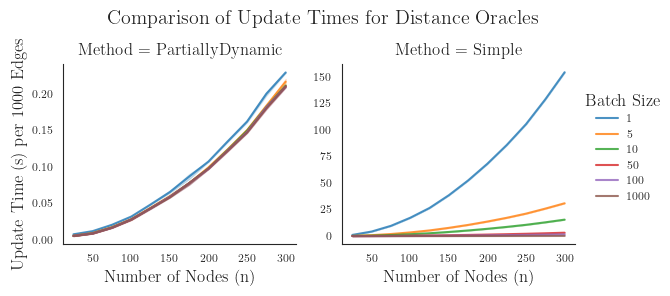

In [205]:
#sns.set_style("white")
plt.figure(figsize=(7, 5))
g = sns.FacetGrid(data=df, col="Method", hue="Batch Size", sharey=False, legend_out=True).map(sns.lineplot, "Number of Nodes (n)", "Update Time (s) per 1000 Edges", errorbar=('sd'), alpha=0.8, )
g.add_legend()
g.figure.subplots_adjust(top=0.8)
g.figure.suptitle("Comparison of Update Times for Distance Oracles")


#sns.lineplot(data=df, x="n", y="update_time", style="batch_size", hue="method", errorbar='sd').set(title="ASPL Time Complexity", xlabel="Number of Nodes (n)", ylabel="Update Time (s) per 1000 Edges")
# Save the plot to an EPS file
plt.savefig('../dissertation/figures/aspl_update_time.pdf', dpi=300, format='pdf', bbox_inches='tight')

/var/folders/xm/ytd6ktbs0_n7mq72_0yz20pr0000gn/T/ipykernel_18818/1120146965.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df2['y_update_hat'] = params[0] + params[1] * (df2.n ** 2) * df2.k / df2.b


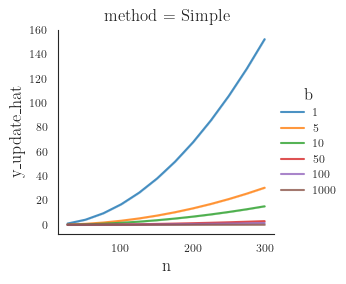

In [246]:
# Create an additional graph with the predicted update time
#df['y_update_hat'] = 
df2['y_update_hat'] = params[0] + params[1] * (df2.n ** 2) * df2.k / df2.b
#df2['y_update_hat'] = (df2.n ** 2)

g = sns.FacetGrid(data=df2, col="method", hue="b", sharey=False, legend_out=True).map(sns.lineplot, "n", "y_update_hat", errorbar=('sd'), alpha=0.8, )
g.add_legend()


<Axes: xlabel='y_update', ylabel='residual'>

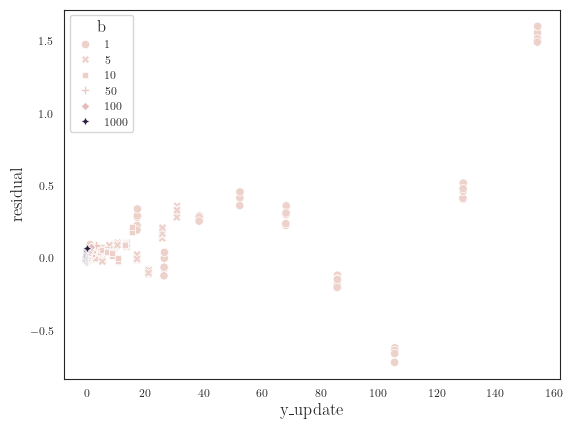

In [247]:
# Plot a residual plot of update time and y_update_hat
df2['residual'] = df2['y_update'] - df2['y_update_hat']
sns.scatterplot(data=df2, x='y_update', y='residual', hue='b', style='b')

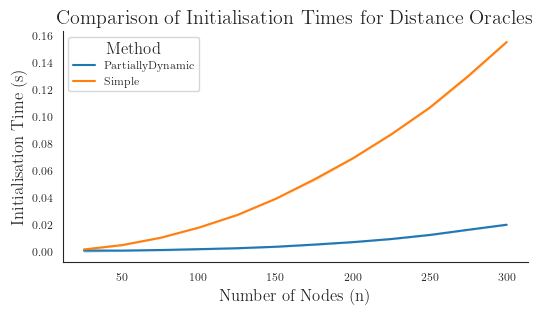

In [203]:
#sns.set_style("white")
plt.figure(figsize=(6, 3))
g = sns.lineplot(data=df, x="Number of Nodes (n)", y="Initialisation Time (s)", hue="Method", errorbar='sd')
g.set(title="Comparison of Initialisation Times for Distance Oracles")
sns.despine(top=True, right=True)
plt.savefig('../dissertation/figures/aspl_init_time.pdf', format='pdf', bbox_inches='tight')